## Github The Most Popular Repos Dataset Review

In [4]:
# Libraries
import altair as alt
import pandas as pd

To review the data set, First of all we need some basic libraries. These are:<br><br>
1.**Altair** _(for visualization)_<br>
2.**Pandas** _(for data analysis and prepare data sets)_

---

In order **to connect bigquery platform**, we need credentials

In [13]:
# connect to bigquery
import json
from google.oauth2 import service_account
from google.cloud import bigquery

path = '/Users/selcu/Desktop/İş Güç/bruin/bruin-hiring-1b27c94e981a.json'

with open(path, 'r') as f:
    json_key_file = json.load(f)
    
credentials = service_account.Credentials.from_service_account_info(json_key_file)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)
datasets = list(client.list_datasets())


---

Before starting there is an important article about why pie charts should not be used:
https://theconversation.com/heres-why-you-should-almost-never-use-a-pie-chart-for-your-data-214576#:~:text=The%20pie%20chart's%20circularity%20means%20the%20areas%20lack%20a%20common%20reference%20point.&text=Pie%20charts%20also%20do%20badly,of%20categories%20in%20one%20pie.

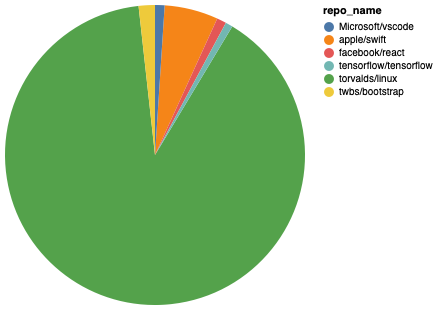

---
---


### Most Popular Repos

By using the Dataset, we can detect the most popular repos with sql queries.

In [25]:
query = """
SELECT
    repo_name as `repo name`,
    COUNT(*) as counter
FROM
    `bruin-hiring.github_repos.sample_commits`
GROUP BY
    `repo name`
ORDER BY
    counter

"""
query_job = client.query(query)
result = query_job.result()

In [26]:
print(result)

---

After query(above code), we need to create a data frame to visualize these data.

In [18]:
x_axis = [] # axis
y_axis = []

for row in result:
    x_axis.append(row[0])
    y_axis.append(row[1])

df = pd.DataFrame({'repo name':x_axis,'count of repos':y_axis})

In [57]:
# dataframe
df

,repo name,count of repos
0,tensorflow/tensorflow,5253
1,facebook/react,6875
2,Microsoft/vscode,6909
3,twbs/bootstrap,11777
4,apple/swift,38891
5,torvalds/linux,602604


---

Here dataset is ready for visualizing. Now we can create a chart.

`.sort()` for sorting

In [64]:
alt.Chart(df).mark_bar().encode(
    
    x=alt.X('repo name',).sort('-y'),
    y=alt.Y('count of repos')
    
)

/Users/selcu/opt/anaconda3/lib/python3.10/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

---
---

### The Top Contributors

SQL Code To Get Contrubitor Data

In [ ]:
query = """
SELECT 
    committer.name as name,
    COUNT(*) as `number of commits`
FROM 
    `bruin-hiring.github_repos.sample_commits`

"""

The detail is that People might have the same name. To prevent this mistake we should check 
mail address(unique).

for instance, a mail address: ` fe08d3c717adf2ae63592e4c9aec6e3e404d8e3e@davemloft.net `

The second detail is that a person can have more than one mail address and these mail address have the same name when person is the same. 

69652caca27c8b940640ad396ab71f93cacec34f@woody.linux-foundation.org 
69652caca27c8b940640ad396ab71f93cacec34f@g5.osdl.org 
69652caca27c8b940640ad396ab71f93cacec34f@linux-foundation.org 

We can notice that before `@` sign, these code are the same, we should be careful about here.

##### we 2 options to make this,

The First option is:
    Prepare new `SQL code` to obtain a new query

In [154]:
query2 = """    
    SELECT
        CONCAT(committer.name, ' ', substr(committer.email,1,40)) as name,
        COUNT(*) as counter
    FROM
        bruin-hiring.github_repos.sample_commits
    GROUP BY
        name
    ORDER BY
        counter
"""

The Second option is:
    Write a `pandas code` **to group the same mail** address(without domain) and name.

In [149]:
query = """
SELECT 
    committer.name,
    committer.email,
    COUNT(*) as counter
FROM
     `bruin-hiring.github_repos.sample_commits`
GROUP BY
    committer.name,
    committer.email
ORDER BY
    counter desc
LIMIT
    10
"""

query_job = client.query(query)
result = query_job.result()

_Building DataFrame_

In [151]:
x_axis = []
y_axis = []

for row in result:
    x_axis.append(row[0]+' '+row[1][:40])
    y_axis.append(row[2])



In [152]:
df = pd.DataFrame({'name of contributor':x_axis,'number of cont':y_axis})
df

,name of contributor,number of cont
0,David S. Miller fe08d3c717adf2ae63592e4c9aec6e...,49523
1,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,40480
2,Greg Kroah-Hartman 4645f7897fd33786a2ee1264d59...,37969
3,Greg Kroah-Hartman 4645f7897fd33786a2ee1264d59...,19605
4,John W. Linville 2a53bac7a5d324865ef46ec4c38b2...,18875
5,Mauro Carvalho Chehab ad86ba2154032c9f55743a19...,13372
6,Ingo Molnar 9dbbbf0688fedc85ad4da37637f1a64b8c...,13311
7,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,12197
8,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,8928
9,Takashi Iwai 4596b3305151c7ee743192a95d394341e...,8661


Here we have a problem. There is more than one Linus Torvalds with the same mail code. To group these rows:

In [157]:
df2 = df.groupby('name of contributor')['number of cont'].sum().reset_index()

In [159]:
df2 = pd.DataFrame(df2)

In [161]:
df2

,name of contributor,number of cont
0,David S. Miller fe08d3c717adf2ae63592e4c9aec6e...,49523
1,Greg Kroah-Hartman 4645f7897fd33786a2ee1264d59...,57574
2,Ingo Molnar 9dbbbf0688fedc85ad4da37637f1a64b8c...,13311
3,John W. Linville 2a53bac7a5d324865ef46ec4c38b2...,18875
4,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,61605
5,Mauro Carvalho Chehab ad86ba2154032c9f55743a19...,13372
6,Takashi Iwai 4596b3305151c7ee743192a95d394341e...,8661


In [136]:
df['number of cont.'] = [int(each) for each in df['number of cont']]

In [138]:
type(df['number of cont.'][1])

numpy.int64

_Visualizing_

In [163]:
df

,name of contributor,number of cont
0,David S. Miller fe08d3c717adf2ae63592e4c9aec6e...,49523
1,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,40480
2,Greg Kroah-Hartman 4645f7897fd33786a2ee1264d59...,37969
3,Greg Kroah-Hartman 4645f7897fd33786a2ee1264d59...,19605
4,John W. Linville 2a53bac7a5d324865ef46ec4c38b2...,18875
5,Mauro Carvalho Chehab ad86ba2154032c9f55743a19...,13372
6,Ingo Molnar 9dbbbf0688fedc85ad4da37637f1a64b8c...,13311
7,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,12197
8,Linus Torvalds 69652caca27c8b940640ad396ab71f9...,8928
9,Takashi Iwai 4596b3305151c7ee743192a95d394341e...,8661


In [169]:
alt.Chart(df2).mark_bar().encode(
    x=alt.X('name of contributor').sort('-y'),
    y=alt.Y('number of cont'))




/Users/selcu/opt/anaconda3/lib/python3.10/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

we have used local parts to detect that people are the same or different.